In [2]:
import pandas as pd
import numpy as np

workdir = "U:/Industrial Heat Survey/Paper Version/Data and analysis/Code/"

file_dir = "U:/Industrial Heat Survey/Paper Version/Data and analysis/Data for calculations/"

target_eu_file = 'C:/Users/cmcmilla/Desktop/GHGRP_output/target_char.csv'

target_energy_file = 'IHS_target_energydata_20170831.csv'

energy_file = "C:/users/cmcmilla/Desktop/GHGRP_output/ghgrp_merged20170831.csv"

emissions_file = "GHGRP_emissions_201015.csv"

target_file = "target_industries.csv"

MECS_FT_file = "MECS_FT_hs.csv"

In [3]:
# Load GHGRP data with calculated combustion energy values and reported emissions 
# (from Subparts C and D in MTCO2e) for 2010 - 2015.

GHGRP_energy = pd.read_csv(energy_file, encoding='latin_1', index_col=0, low_memory=False)

GHGRP_emissions = pd.read_csv(workdir + emissions_file, encoding='latin_1')

GHGRP_emissions = pd.DataFrame(GHGRP_emissions[(GHGRP_emissions.SUBPART_NAME == 'C') |
                                               (GHGRP_emissions.SUBPART_NAME == 'D') |
                                               (GHGRP_emissions.SUBPART_NAME == 'AA')
                                              ])

GHGRP_emissions.rename(columns={'YEAR': 'REPORTING_YEAR'}, inplace=True)


FileNotFoundError: File b'C:/users/cmcmilla/Desktop/GHGRP_output/ghgrp_merged20170831.csv' does not exist

In [40]:
# Identify facilities that reported a primary or secondary NAICS code that matches the list of 14 'target industries' identified
# by McMillan et al. (2016)

targetind = pd.read_csv(workdir + target_file, index_col='NAICS')

GHGRP_energy.SECONDARY_NAICS_CODE.fillna(0, inplace=True)

GHGRP_energy.loc[:, 'SECONDARY_NAICS_CODE'] = GHGRP_energy.SECONDARY_NAICS_CODE.astype(np.int64)

target_201015 = pd.DataFrame(
    GHGRP_energy[(GHGRP_energy.PRIMARY_NAICS_CODE.apply(lambda x: x in targetind.index)) |
                            (GHGRP_energy.SECONDARY_NAICS_CODE.apply(lambda x: x in targetind.index))]
    )

In [41]:
# Map GHGRP-reported fuel types to fuel types used in Manufacturing Energy Consumption Survey (biogenic materials, excluding
# municipal solid waste, are broken out of "Other")

MECS_FT_dict = dict(pd.read_csv(workdir + MECS_FT_file).values)

target_201015.loc[:, 'MECS_FT'] = ''

for c in ['FUEL_TYPE', 'FUEL_TYPE_OTHER', 'FUEL_TYPE_BLEND']:
    grouped = target_201015.groupby(c)
    for g in grouped.groups:
        target_201015.loc[grouped.get_group(g).index, 'MECS_FT'] = grouped.get_group(g)[c].apply(lambda x: MECS_FT_dict[x])


In [42]:
# Create new column 'FINAL_NAICS_CODE' with NAICS code selected to represent the production activities of each facility
# identified as being part of the 'target industries'. Identification based on either reported primary or secondary NAICS code.
target_201015.loc[:, 'FINAL_NAICS_CODE'] = 0

target_201015.FINAL_NAICS_CODE.update(
    target_201015[(target_201015.PRIMARY_NAICS_CODE.apply(lambda x: x not in targetind.index)) & 
               (target_201015.SECONDARY_NAICS_CODE.apply(lambda x: x in targetind.index))
               ].SECONDARY_NAICS_CODE
    )

target_201015.FINAL_NAICS_CODE.update(
    target_201015[(target_201015.PRIMARY_NAICS_CODE.apply(lambda x: x in targetind.index)) & 
               (target_201015.SECONDARY_NAICS_CODE.apply(lambda x: x not in targetind.index))
               ].PRIMARY_NAICS_CODE
    )

target_201015.FINAL_NAICS_CODE.update(
    target_201015[(target_201015.PRIMARY_NAICS_CODE.apply(lambda x: x in targetind.index)) & 
               (target_201015.SECONDARY_NAICS_CODE.apply(lambda x: x in targetind.index))
               ].PRIMARY_NAICS_CODE
    )

In [43]:
# Attach GHGRP-reported emissions [V_GHG_EMITTER_SUBPART] for 
# Subparts C & D [stationary combustion emissions and emissions from electricity generation].

GHGRP_emissions.loc[:, 'FINAL_NAICS_CODE'] = GHGRP_emissions.FACILITY_ID.map(
    dict(target_201015[['FACILITY_ID', 'FINAL_NAICS_CODE']].values)
    )

GHGRP_emissions.dropna(subset = ['FINAL_NAICS_CODE'], inplace=True)

GHGRP_emissions.loc[:, 'FINAL_NAICS_CODE'] = [int(x) for x in GHGRP_emissions.FINAL_NAICS_CODE.values]

emissions_summary = pd.DataFrame(GHGRP_emissions.groupby(['REPORTING_YEAR', 'FINAL_NAICS_CODE']).CO2E_EMISSION.sum())


In [44]:
# Identify which facilities have increased or decreased emissions since their first reporting year
first_y = GHGRP_emissions.groupby('FACILITY_ID').REPORTING_YEAR.min()

last_y = GHGRP_emissions.groupby('FACILITY_ID').REPORTING_YEAR.max()

trend_ghgs = pd.DataFrame(index = first_y.index, columns = ['FIRST', 'LAST'])

for f, y in first_y.to_dict().items():
    trend_ghgs.loc[f, 'FIRST'] = GHGRP_emissions.groupby(['FACILITY_ID', 'REPORTING_YEAR']).get_group((f,y)).CO2E_EMISSION.sum()
    
for f, y in last_y.to_dict().items():
    trend_ghgs.loc[f, 'LAST'] = GHGRP_emissions.groupby(['FACILITY_ID', 'REPORTING_YEAR']).get_group((f,y)).CO2E_EMISSION.sum()
    
# Drop facilities with only one year of reporting
trend_ghgs = pd.DataFrame(trend_ghgs[first_y != last_y])

trend_ghgs.loc[:, 'DECREASED'] = trend_ghgs.FIRST > trend_ghgs.LAST

In [45]:
# Explore by emissions decile if facilities have decreased emissions
trend_ghgs.loc[:, 'DECREASED'] = trend_ghgs.FIRST > trend_ghgs.LAST

trend_ghgs.loc[:, 'DECILE'] = pd.qcut(trend_ghgs.LAST, 10, retbins=True)[0]

dbins = pd.qcut(trend_ghgs.LAST, 10, retbins=True)[1]

np.round(
    trend_ghgs.groupby(['DECILE', 'DECREASED']).FIRST.count()  / trend_ghgs.groupby(['DECILE']).FIRST.count(), decimals=2
    )

DECILE                     DECREASED
[4.4, 23882.18]            False        0.26
                           True         0.74
(23882.18, 38449.984]      False        0.43
                           True         0.57
(38449.984, 54727.394]     False        0.54
                           True         0.46
(54727.394, 78737.615]     False        0.58
                           True         0.42
(78737.615, 106339.9]      False        0.49
                           True         0.51
(106339.9, 167482.0384]    False        0.48
                           True         0.52
(167482.0384, 334498.654]  False        0.56
                           True         0.44
(334498.654, 675998.504]   False        0.54
                           True         0.46
(675998.504, 1388499.24]   False        0.52
                           True         0.48
(1388499.24, 7799015.14]   False        0.52
                           True         0.48
Name: FIRST, dtype: float64

(1, 10000000)

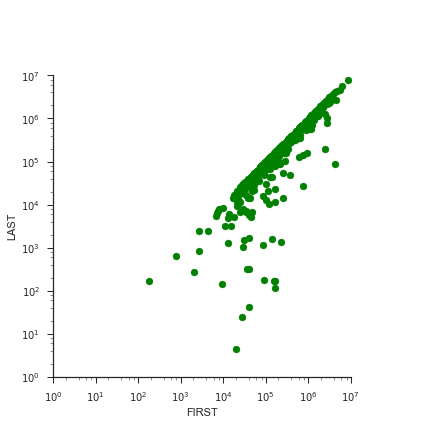

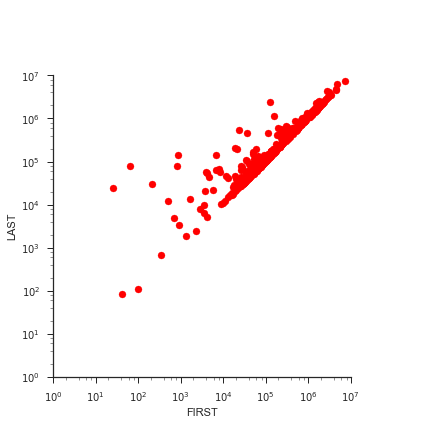

In [46]:
# Plot first and last year facility GHG emissions
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib as mpl
%matplotlib inline
sns.set(style='ticks')

g_firstlast = sns.JointGrid(trend_ghgs[trend_ghgs.DECREASED == True].FIRST, trend_ghgs[trend_ghgs.DECREASED == True].LAST)
g_firstlast.plot_joint(plt.scatter, color='g')
#jointplot(x='FIRST', y='LAST', data=trend_ghgs, kind='scatter', stat_func=None)

ax = g_firstlast.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g_firstlast.ax_marg_x.set_axis_off()
g_firstlast.ax_marg_y.set_axis_off()
ax.set_ylim(1, 10000000)
ax.set_xlim(1, 10000000)

g_firstlast = sns.JointGrid(trend_ghgs[trend_ghgs.DECREASED == False].FIRST, trend_ghgs[trend_ghgs.DECREASED == False].LAST)
g_firstlast.plot_joint(plt.scatter, color='r')

ax = g_firstlast.ax_joint
ax.set_xscale('log')
ax.set_yscale('log')
g_firstlast.ax_marg_x.set_axis_off()
g_firstlast.ax_marg_y.set_axis_off()
ax.set_ylim(1, 10000000)
ax.set_xlim(1, 10000000)


In [29]:
target_201015.drop_duplicates(subset='FACILITY_ID')[['FACILITY_ID', 'FINAL_NAICS_CODE']].to_csv('naics_matched_examine.csv')

In [47]:
# There are instances where facilities appear in V_GHG_EMITTER_SUBPART but not C_FUEL_LEVEL_INFORMATION and vice versa
# for certain years. Identify facility count by reporting year and final naics code and calculate  
# the difference between number of facilities provided by C_FUEL_INFORMATION and V_GHG_EMITTER_SUBPART

target_naics = targetind.index.values

def fac_counts(df, naics):
    df_grouped = df[df.FINAL_NAICS_CODE.apply(lambda x: x in naics)].groupby(['REPORTING_YEAR', 'FINAL_NAICS_CODE'])
    
    fac_counts = df_grouped.FACILITY_ID.apply(lambda x: np.size(np.unique(x)))
    
    return fac_counts

faccount_dict = {}

for n in ['energy', 'emissions']:
    if n == 'energy':
        df = GHGRP_emissions
        
    else:
        df = target_201015
        
    faccount_dict[n] = fac_counts(df, target_naics)
    
count_compare = pd.DataFrame((faccount_dict['emissions'] - faccount_dict['energy']))

#faccount_dict['emissions'].to_csv('fac_count_examine.csv')


In [54]:
# Output target dataframe, converting MMBtu to TJ
target_out = pd.DataFrame(target_201015, copy=False)

target_out.loc[:, 'TJ'] = target_out.MMBtu_TOTAL * 0.001055

target_out.to_csv('IHS_target_energydata_20170831.csv')

In [49]:
# Group by reporting year and NAICS code, and convert to TJ
ind_summary = pd.DataFrame(target_201015.groupby(['REPORTING_YEAR', 'FINAL_NAICS_CODE']).MMBtu_TOTAL.sum() * 0.001055)

for g in emissions_summary.index:
    ind_summary.loc[g, 'CO2E_EMISSION'] = emissions_summary.to_dict(orient='index')[g]['CO2E_EMISSION']
    
ind_summary.rename(columns = {'MMBtu_TOTAL': 'TJ_TOTAL'}, inplace=True)

ind_index_val = pd.DataFrame()

for y in ind_summary.index.levels[0]:
    ind_index_val = ind_index_val.append(
        ind_summary[ind_summary.index.get_level_values('REPORTING_YEAR') == y].divide(
                ind_summary[ind_summary.index.get_level_values('REPORTING_YEAR') == 2010].values, axis = 0
                ) * 100
              )

# Index NAICS 311221 and NAICS 325193 to 2011 values based on missing facility data for 2010
def New_index_vals(naics, year, ind_index_val):
    
    new_vals = ind_summary[ind_summary.index.get_level_values('FINAL_NAICS_CODE') == naics].divide(
        ind_summary.loc[year, naics].values
        ) * 100
    
    new_vals.drop(new_vals[new_vals.index.get_level_values('REPORTING_YEAR') == 2010].index, inplace=True)
    
    ind_index_val.drop(ind_index_val[ind_index_val.index.get_level_values('FINAL_NAICS_CODE') == naics].index, inplace=True)
    
    for y in ind_index_val.index.levels[0][1:]:
        ind_index_val = ind_index_val.append(new_vals.loc[y, naics])
        
    return ind_index_val


ind_index_val = New_index_vals(311221, 2011, ind_index_val)

ind_index_val = New_index_vals(325193, 2011, ind_index_val)
    
#index_val311221 = \
#    ind_summary[ind_summary.index.get_level_values('FINAL_NAICS_CODE') == 311221].divide(ind_summary.loc[2011, 311221].values) \
#    * 100

#index_val311221.drop(index_val311221[index_val311221.index.get_level_values('REPORTING_YEAR') == 2010].index, inplace=True)

#ind_index_val.drop(ind_index_val[ind_index_val.index.get_level_values('FINAL_NAICS_CODE') == 311221].index, inplace=True)

#for y in ind_index_val.index.levels[0][1:]:
#    ind_index_val = ind_index_val.append(index_val311221.loc[y, 311221])

ind_index_val.rename(columns = {'TJ_TOTAL': 'TJ_index', 'CO2E_EMISSION': 'CO2E_index'}, inplace=True)

ind_index_val.reset_index(inplace=True)

ind_index_val = pd.DataFrame(
    ind_index_val[['TJ_index', 'CO2E_index']].values, index=[ind_index_val.REPORTING_YEAR, ind_index_val.FINAL_NAICS_CODE],
    columns=['TJ_index', 'CO2E_index']
    )

ind_summary = pd.concat([ind_summary, ind_index_val], axis=1)

ind_summary.reset_index(inplace=True)

ind_summary= pd.melt(
    ind_summary, id_vars = ['REPORTING_YEAR', 'FINAL_NAICS_CODE'], \
    value_vars = ['TJ_TOTAL', 'CO2E_EMISSION', 'TJ_index', 'CO2E_index']
    )

ind_summary_fuels = \
    pd.DataFrame(target_201015.groupby(['REPORTING_YEAR', 'FINAL_NAICS_CODE', 'MECS_FT']).MMBtu_TOTAL.sum() * 0.001055)

ind_summary_fuels.reset_index(inplace=True)

ind_summary_fuels.rename(columns={'MECS_FT': 'variable', 'MMBtu_TOTAL': 'value'}, inplace=True)

ind_summary = ind_summary.append(ind_summary_fuels)

ind_summary.dropna(axis=0, how='any', inplace=True)

In [50]:
ind_summary_fuels.head()

,REPORTING_YEAR,FINAL_NAICS_CODE,variable,value
0,2010,212391,Coal,45450.524629
1,2010,212391,Diesel,10.977934
2,2010,212391,Natural_gas,31897.443828
3,2010,212391,Other,54.501761
4,2010,311221,Bio,347.736988


In [51]:
# Calculate dataframe for fuel type fraction of total calculate energy.
ind_summary_fuelfrac = ind_summary_fuels.set_index(['REPORTING_YEAR', 'FINAL_NAICS_CODE'], drop=True)

for i in ind_summary_fuelfrac.index.drop_duplicates():
            ind_summary_fuelfrac.loc[i, 'total'] = \
                ind_summary[(ind_summary.REPORTING_YEAR == i[0]) & 
                        (ind_summary.FINAL_NAICS_CODE == i[1]) & 
                        (ind_summary.variable == 'TJ_TOTAL')].value.values[0]

ind_summary_fuelfrac.loc[:, 'value'] = ind_summary_fuelfrac['value'].divide(ind_summary_fuelfrac['total'])

ind_summary_fuelfrac.reset_index(inplace=True)

ind_summary_fuelfrac.drop('total', inplace=True, axis=1)


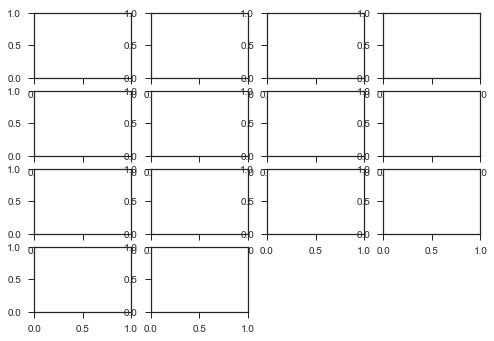

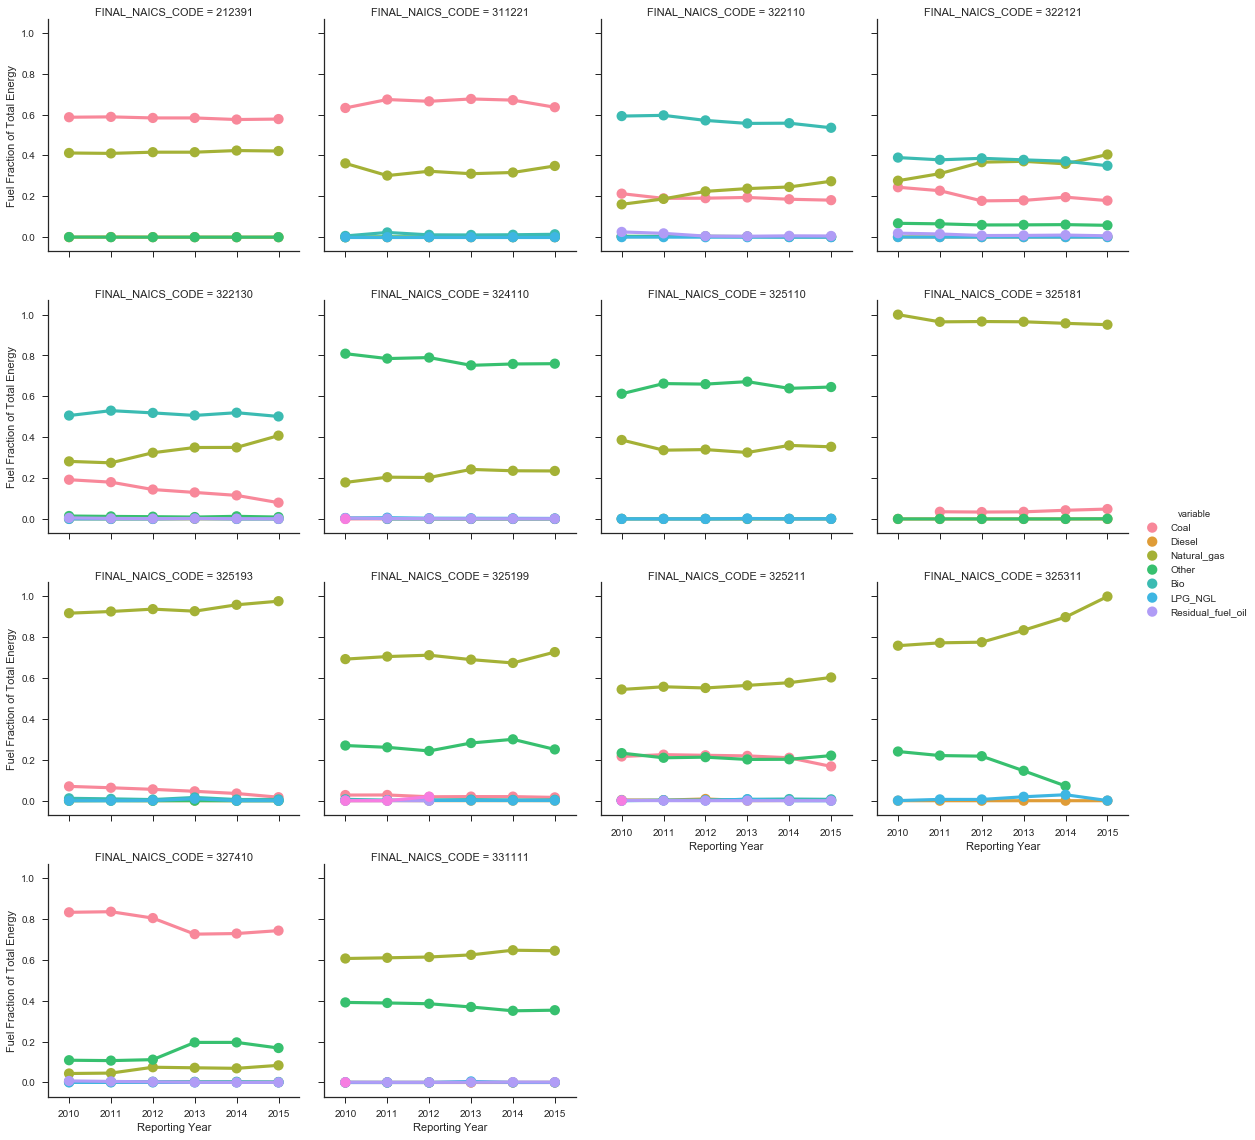

In [53]:
# Plot fuel fraction of total calculated energy by year and NAICS


g_fuels = sns.factorplot(
    x = 'REPORTING_YEAR', y = 'value', col = 'FINAL_NAICS_CODE', col_wrap = 4, hue = 'variable', kind='point',
    data = ind_summary_fuelfrac)


g_fuels.set_axis_labels('Reporting Year', 'Fuel Fraction of Total Energy')

In [50]:
xl_writer = pd.ExcelWriter('Diff_' + str(n_examine) + '.xls')

for f in ['FUEL_TYPE', 'FUEL_TYPE_OTHER', 'FUEL_TYPE_BLEND']:
    file = str(n_examine) + f 
    pd.DataFrame(pd.pivot_table(target_201015[target_201015.FINAL_NAICS_CODE == n_examine], values=['MMBtu_TOTAL'], 
               index = [f], 
               columns = ['REPORTING_YEAR'], aggfunc = np.sum, fill_value = 'na'
               )).to_excel(xl_writer, file)

pd.DataFrame(target_201015[target_201015.FINAL_NAICS_CODE == n_examine].FACILITY_ID.drop_duplicates()).to_excel(xl_writer,
    'fac_ID_' + str(n_examine) + '.csv')

xl_writer.save()


In [51]:
pd.pivot_table(target_201015[(target_201015.FINAL_NAICS_CODE == n_examine)], 
               values=['MMBtu_TOTAL'], index=['FACILITY_ID'], columns=['REPORTING_YEAR'], aggfunc = np.sum)



MMBtu_TOTAL                                            \
REPORTING_YEAR          2010          2011          2012          2013   
FACILITY_ID                                                              
1000261         1.104416e+07  9.932589e+06  1.202800e+07  1.187596e+07   
1000304                  NaN  1.307842e+06  1.300579e+06  1.360486e+06   
1000334         9.101896e+06  8.875515e+06  9.300411e+06  9.745026e+06   
1000401         5.604274e+06  4.148252e+06  3.531710e+06  5.184047e+06   
1000407                  NaN  4.614673e+06  4.220974e+06  4.423746e+06   
1001090                  NaN  1.412658e+06  1.425396e+06  1.437257e+06   
1001293         6.397132e+06  6.350650e+06  5.932801e+06  6.470441e+06   
1001675         2.289503e+06  2.374953e+06  2.344595e+06  2.475008e+06   
1001945                  NaN  3.500777e+06  3.311116e+06  3.176135e+06   
1002632         2.333242e+06  2.301611e+06  2.317252e+06  2.353303e+06   
1002916                  NaN  1.287307e+07  1.492530e+07  1.455096e+07   
1003513         6.509687e+05  6.159461e+05  5.903656e+05  5.500151e+05   
1004114         7.138323e+06  8.220463e+06  5.932699e+06  7.603002e+06   
1004640         4.066559e+06  3.420193e+06  3.292029e+06  4.198595e+06   
1005479         1.738343e+06  1.686600e+06  1.534886e+06  1.180167e+06   
1005661                  NaN  5.287095e+07  5.382124e+07  5.334761e+07   
1005988         3.568760e+06  3.396231e+06  3.567056e+06  3.524488e+06   
1006047                  NaN  1.453163e+07  3.435229e+07  3.241021e+07   
1006208                  NaN  2.245713e+07  2.140449e+07  2.314035e+07   
1006425                  NaN  6.526415e+06  7.721249e+06  8.801657e+06   
1006525                  NaN  1.573236e+06  1.680192e+06  1.716912e+06   
1006637                  NaN  3.911450e+06  3.868006e+06  3.777820e+06   
1007881                  NaN  7.514701e+06  7.597016e+06  7.546249e+06   
1010590                  NaN           NaN  8.909574e+05  1.472066e+06   

                                            
REPORTING_YEAR          2014          2015  
FACILITY_ID                                 
1000261         1.058103e+07  1.019403e+07  
1000304         1.309267e+06  1.324775e+06  
1000334         1.070686e+07  8.850226e+06  
1000401         5.194745e+06  4.324063e+06  
1000407         4.594017e+06  8.027300e+05  
1001090         1.499700e+06  1.570129e+06  
1001293         6.349800e+06  6.668289e+06  
1001675         2.462230e+06  2.481313e+06  
1001945         3.147461e+06  3.283499e+06  
1002632         2.425000e+06  2.373957e+06  
1002916         1.470087e+07  1.330864e+07  
1003513         5.585020e+05  5.710765e+05  
1004114         8.600746e+06  5.480349e+06  
1004640         4.282671e+06  4.114151e+06  
1005479         1.177120e+06  1.245162e+06  
1005661         5.394386e+07  5.107476e+07  
1005988         3.580091e+06  3.580483e+06  
1006047         3.132485e+07  3.268335e+07  
1006208         2.325890e+07  2.284935e+07  
1006425         9.710528e+06  9.565518e+06  
1006525         1.994791e+06  1.971296e+06  
1006637         4.802506e+06  3.943194e+06  
1007881         7.882473e+06  7.920424e+06  
1010590         1.543349e+06  1.437352e+06

In [155]:
# Summary of calculated energy use by fuel for target industries

test = pd.DataFrame(target_201015.groupby(['FINAL_NAICS_CODE','FUEL_TYPE','REPORTING_YEAR']).MMBtu_TOTAL.sum() * 0.001055)

pd.pivot_table(target_201015, values = ['CO2e_TOTAL', 'MMBtu_TOTAL'], 
               index = ['FINAL_NAICS_CODE', 'FUEL_TYPE'], 
               columns = ['REPORTING_YEAR'], aggfunc = np.sum, fill_value = 0
               ).to_csv('test_2.csv')


